## H&M Personalized Fashion Recommendations
## Provide product recommendations based on previous purchases
![](https://storage.googleapis.com/kaggle-competitions/kaggle/31254/logos/header.png?t=2021-10-26-22-52-52")

## Data Description
For this challenge you are given the purchase history of customers across time, along with supporting metadata. Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.

## Files
images/ - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

articles.csv - detailed metadata for each article_id available for purchase

customers.csv - metadata for each customer_id in dataset

sample_submission.csv - a sample submission file in the correct format

transactions_train.csv - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

NOTE: You must make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

## Evaluation

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12):

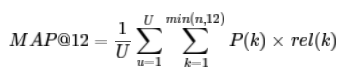

Notes:

You will be making purchase predictions for all customer_id values provided, regardless of whether these customers made purchases in the training data.
Customer that did not make any purchase during test period are excluded from the scoring.
There is never a penalty for using the full 12 predictions for a customer that ordered fewer than 12 items; thus, it's advantageous to make 12 predictions for each customer.

## Import packages

In [ ]:
# Install packages if required

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import os
from tqdm import tqdm
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import calendar
import warnings
warnings.filterwarnings("ignore")
import torch
from torch.utils import data as torch_data

## Load data

In [ ]:
articles_data = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
customers_data = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv')
transactions_train = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
sample_submission = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')

## EDA

In [ ]:
# pd.set_option('display.max_columns', None)
print(articles_data.shape, articles_data['article_id'].nunique())
articles_data.head()

In [ ]:
articles_data.columns

In [ ]:
print(customers_data.shape, customers_data['customer_id'].nunique())
customers_data.head()

In [ ]:
print(transactions_train.shape, transactions_train['customer_id'].nunique())
transactions_train.head()

In [ ]:
article_ids_master = set(articles_data['article_id'].unique().tolist())
article_ids_train = set(transactions_train['article_id'].unique().tolist())
print('# New articles found in transactions train data (not in master articles data):', len(article_ids_train) - len(article_ids_train.intersection(article_ids_master)))

In [ ]:
# See transactions for a single customer
cust_id = customers_data['customer_id'].iloc[0]
transactions_train[transactions_train['customer_id']==cust_id]

In [ ]:
print(sample_submission.shape)
print('\nSample article IDs:', sample_submission['prediction'].iloc[0], '\n# articles:', len(sample_submission['prediction'].iloc[0].split(' ')))
sample_submission.head()

In [ ]:
cust_ids_test_data = set(sample_submission['customer_id'].unique().tolist())
cust_ids_train_data = set(transactions_train['customer_id'].unique().tolist())
print('# Customers in test data:',len(cust_ids_test_data))
print('# New customers found in test data (not in train data):', len(cust_ids_test_data) - len(cust_ids_test_data.intersection(cust_ids_train_data)))

### Distribution by sales and customers - Top products, product types, department, etc.

In [ ]:
num_customers_by_article = transactions_train.groupby(['article_id']).agg({'customer_id':['count', 'nunique'], 'price':['mean','max','min']}).reset_index()
num_customers_by_article.columns = ['article_id', '# Transactions', '# Customers', 'Average price', 'Max. price', 'Min. price']
num_customers_by_article = num_customers_by_article.sort_values(by = ['# Customers'], ascending = False)
num_customers_by_article = num_customers_by_article.merge(articles_data, how = 'left', on = 'article_id')

In [ ]:
articles_data.shape, num_customers_by_article.shape

In [ ]:
num_customers_by_prod_name = num_customers_by_article.groupby(['prod_name']).agg({'# Transactions':'sum', '# Customers':'sum', 'Average price':'mean'}).reset_index()
num_customers_by_prod_type = num_customers_by_article.groupby(['product_type_name']).agg({'# Transactions':'sum', '# Customers':'sum', 'Average price':'mean'}).reset_index()
num_customers_by_department_name = num_customers_by_article.groupby(['department_name']).agg({'# Transactions':'sum', '# Customers':'sum', 'Average price':'mean'}).reset_index()
num_customers_by_section_name = num_customers_by_article.groupby(['section_name']).agg({'# Transactions':'sum', '# Customers':'sum', 'Average price':'mean'}).reset_index()
num_customers_by_garment_group_name = num_customers_by_article.groupby(['garment_group_name']).agg({'# Transactions':'sum', '# Customers':'sum', 'Average price':'mean'}).reset_index()

In [ ]:
print('\n# Unique product names:', num_customers_by_prod_name['prod_name'].nunique())
fig = px.bar(num_customers_by_prod_name.sort_values(by = ['# Transactions'], ascending = False).head(10), x='prod_name', y='# Transactions', title = 'Top product names by # transactions', hover_data = ['# Transactions', '# Customers', 'Average price'])
py.offline.iplot(fig)

fig = px.bar(num_customers_by_prod_name.sort_values(by = ['# Customers'], ascending = False).head(10), x='prod_name', y='# Customers', title = 'Top product names by # customers', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='green')
py.offline.iplot(fig)

fig = px.bar(num_customers_by_prod_name.sort_values(by = ['Average price'], ascending = False).head(10), x='prod_name', y='Average price', title = 'Top product names by average price', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='grey')
py.offline.iplot(fig)

In [ ]:
print('\n# Unique product types:', num_customers_by_prod_type['product_type_name'].nunique())
fig = px.bar(num_customers_by_prod_type.sort_values(by = ['# Transactions'], ascending = False).head(10), x='product_type_name', y='# Transactions', title = 'Top product types by # transactions', hover_data = ['# Transactions', '# Customers', 'Average price'])
py.offline.iplot(fig)

fig = px.bar(num_customers_by_prod_type.sort_values(by = ['# Customers'], ascending = False).head(10), x='product_type_name', y='# Customers', title = 'Top product types by # customers', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='green')
py.offline.iplot(fig)

fig = px.bar(num_customers_by_prod_type.sort_values(by = ['Average price'], ascending = False).head(10), x='product_type_name', y='Average price', title = 'Top product types by average price', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='grey')
py.offline.iplot(fig)

In [ ]:
print('\n# Unique department names:', num_customers_by_department_name['department_name'].nunique())
fig = px.bar(num_customers_by_department_name.sort_values(by = ['# Transactions'], ascending = False).head(10), x='department_name', y='# Transactions', title = 'Top department names by # transactions', hover_data = ['# Transactions', '# Customers', 'Average price'])
py.offline.iplot(fig)

fig = px.bar(num_customers_by_department_name.sort_values(by = ['# Customers'], ascending = False).head(10), x='department_name', y='# Customers', title = 'Top department names by # customers', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='green')
py.offline.iplot(fig)

fig = px.bar(num_customers_by_department_name.sort_values(by = ['Average price'], ascending = False).head(10), x='department_name', y='Average price', title = 'Top department names by average price', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='grey')
py.offline.iplot(fig)

In [ ]:
print('\n# Unique section names:', num_customers_by_section_name['section_name'].nunique())
fig = px.bar(num_customers_by_section_name.sort_values(by = ['# Transactions'], ascending = False).head(10), x='section_name', y='# Transactions', title = 'Top section names by # transactions', hover_data = ['# Transactions', '# Customers', 'Average price'])
py.offline.iplot(fig)

fig = px.bar(num_customers_by_section_name.sort_values(by = ['# Customers'], ascending = False).head(10), x='section_name', y='# Customers', title = 'Top section names by # customers', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='green')
py.offline.iplot(fig)

fig = px.bar(num_customers_by_section_name.sort_values(by = ['Average price'], ascending = False).head(10), x='section_name', y='Average price', title = 'Top section names by average price', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='grey')
py.offline.iplot(fig)

In [ ]:
print('\n# Unique garment group names:', num_customers_by_garment_group_name['garment_group_name'].nunique())
fig = px.bar(num_customers_by_garment_group_name.sort_values(by = ['# Transactions'], ascending = False).head(10), x='garment_group_name', y='# Transactions', title = 'Top garment group names by # transactions', hover_data = ['# Transactions', '# Customers', 'Average price'])
py.offline.iplot(fig)

fig = px.bar(num_customers_by_garment_group_name.sort_values(by = ['# Customers'], ascending = False).head(10), x='garment_group_name', y='# Customers', title = 'Top garment group names by # customers', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='green')
py.offline.iplot(fig)

fig = px.bar(num_customers_by_garment_group_name.sort_values(by = ['Average price'], ascending = False).head(10), x='garment_group_name', y='Average price', title = 'Top garment group names by average price', hover_data = ['# Transactions', '# Customers', 'Average price'])
fig.update_traces(marker_color='grey')
py.offline.iplot(fig)

### Distribution of customers - Top customers by clubmembership, fashion news follower, etc.

In [ ]:
print(transactions_train.shape)
transactions_train = transactions_train.merge(customers_data, how = 'left', on=['customer_id'])
print(transactions_train.shape)

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
customers_data['age group'] = pd.cut(customers_data.age, bins, labels = labels,include_lowest = True)
transactions_train['age group'] = pd.cut(transactions_train.age, bins, labels = labels,include_lowest = True)

In [ ]:
print('# Total customers:', customers_data['customer_id'].nunique())
print('# Total customers with transactions:', transactions_train['customer_id'].nunique())
transactions_train.head()

In [ ]:
top_customers = transactions_train.groupby(['customer_id']).agg({'article_id':['count','nunique'], 'price':['mean','max','min']}).reset_index()
top_customers.columns = ['customer_id', '# Transactions', '# Unique articles bought', 'Average price', 'Max. price', 'Min. price']
top_customers = top_customers.merge(customers_data, on = 'customer_id', how = 'left')

In [ ]:
top_customers.sort_values(by = '# Transactions', ascending = False).head(10)

In [ ]:
temp = top_customers.sort_values(by = ['# Transactions'], ascending = False).head(1000)
fig = px.scatter(temp, x='# Transactions', y="Average price", hover_data = ['# Unique articles bought', 'Max. price', 'Min. price', 'age group', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency'], title = 'Top 1000 customers by # transactions')
py.offline.iplot(fig)

In [ ]:
temp = top_customers.sort_values(by = ["Average price"], ascending = False).head(1000)
fig = px.scatter(temp, y='# Transactions', x="Average price", hover_data = ['# Unique articles bought', 'Max. price', 'Min. price', 'age group', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency'], title = 'Top 1000 customers by average price')
py.offline.iplot(fig)

In [ ]:
lst = ['age group', 'club_member_status', 'fashion_news_frequency']
specs = [[{'type':'domain'}] * 3] * 1

for col_name in ['# Transactions', 'customer_id', '# Unique articles bought', 'Average price']:
    fig = make_subplots(
            rows=1,
            cols=3,
            specs=specs,
            print_grid=False)

    for i, l in enumerate(lst):
        # basic math to get col and row
        row = 1
        col = i+1
        # this is the dataframe for every continent
        d = l
        temp = top_customers.groupby([d]).agg({'customer_id':'count','# Transactions':'sum', '# Unique articles bought':'sum', 'Average price':'mean'}).reset_index()
        fig.add_trace(
            go.Pie(labels=temp[d],
                   values=temp[col_name],
                   showlegend=False,
                   textposition='inside',
                   textinfo='label+percent',
                   title='Distribution by ' + d),
             row=row,
             col=col
        )
    fig.update_layout(title="Distribution of " + col_name + " by customer metadata", title_x=0.5)
    py.offline.iplot(fig)

## Transactions data - summaries based on time

In [ ]:
transactions_train['Date'] = pd.to_datetime(transactions_train['t_dat'])
transactions_train['Year'] = transactions_train['Date'].dt.year
transactions_train['Month'] = transactions_train['Date'].dt.month
transactions_train['Day'] = transactions_train['Date'].dt.day

In [ ]:
transactions_train.head(2)

In [ ]:
temp = transactions_train.groupby(['Year']).agg({'customer_id':['count', 'nunique']}).reset_index()
temp.columns = ['Year', '# Transactions', '# Customers']
temp = temp.sort_values(by = ['Year'], ascending = True)
temp['Year'] = temp['Year'].astype(str)
print('\nYears:', transactions_train['Year'].min(), 'to', transactions_train['Year'].max())
fig = px.bar(temp, x='Year', y='# Transactions', title = '# Transactions by year', hover_data = ['# Customers'])
py.offline.iplot(fig)

fig = px.bar(temp, x='Year', y='# Customers', title = '# Customers by year', hover_data = ['# Transactions'])
fig.update_traces(marker_color='green')
py.offline.iplot(fig)

In [ ]:
temp = transactions_train.groupby(['Month']).agg({'customer_id':['count', 'nunique']}).reset_index()
temp.columns = ['Month', '# Transactions', '# Customers']
temp = temp.sort_values(by = ['Month'], ascending = True)
temp['Month'] = temp['Month'].apply(lambda x: calendar.month_name[x])
fig = px.bar(temp, x='Month', y='# Transactions', title = '# Transactions by month', hover_data = ['# Customers'])
py.offline.iplot(fig)

fig = px.bar(temp, x='Month', y='# Customers', title = '# Customers by month', hover_data = ['# Transactions'])
fig.update_traces(marker_color='green')
py.offline.iplot(fig)

In [ ]:
temp = transactions_train.groupby(['Year','Month']).agg({'customer_id':['count', 'nunique']}).reset_index()
temp.columns = ['Year', 'Month', '# Transactions', '# Customers']
temp['Year-Month'] = temp['Year'].astype(str) + '-' + temp['Month'].astype(str)
temp = temp.sort_values(by = ['Year', 'Month'], ascending = True)
fig = px.line(temp, x="Year-Month", y="# Transactions", title='# Transactions across time')
py.offline.iplot(fig)

In [ ]:
customer_id = top_customers.sort_values(by = ['# Transactions'], ascending = False)['customer_id'].iloc[0] # Specify any customer ID

temp = transactions_train[transactions_train['customer_id']==customer_id]
temp = temp.groupby(['Year','Month']).agg({'customer_id':['count']}).reset_index()
temp.columns = ['Year', 'Month', '# Transactions']
temp['Year-Month'] = temp['Year'].astype(str) + '-' + temp['Month'].astype(str)
temp = temp.sort_values(by = ['Year', 'Month'], ascending = True)
fig = px.line(temp, x="Year-Month", y="# Transactions", title='# Transactions across time for customer ID: '+ str(customer_id))
py.offline.iplot(fig)

### Images of articles

In [ ]:
articles_data['image_path'] = np.NaN

In [ ]:
file_path = '../input/h-and-m-personalized-fashion-recommendations/images'
image_file_paths = []
for folder in tqdm(os.listdir(file_path)):
    images = os.listdir(file_path + '/' + folder)
    for img in images:
        article_id = img.split('.jpg')[0]
        articles_data['image_path'] = np.where(articles_data['article_id']==int(article_id), file_path + '/' + folder + '/' + img, articles_data['image_path'])

In [ ]:
article_ids_master = set(articles_data['article_id'].tolist())
article_ids_with_transactions = set(transactions_train[['article_id']].drop_duplicates()['article_id'].tolist())
article_ids_with_images = set(articles_data[articles_data['image_path'].notna()]['article_id'].tolist())
venn2((article_ids_with_transactions, article_ids_with_images), set_labels = ('Articles with transactions', 'Articles with images'))

Almost all articles have images

In [ ]:
articles_data.head(2)

In [ ]:
print('\nSample 10 images\n')
article_id = articles_data[articles_data['image_path']!='nan']['article_id'].sample(10).tolist() # Specify list of article IDs
    
rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize=(50, 25))

count = 0
for a in range(rows*cols):
    img_path = articles_data[articles_data['article_id']==article_id[count]]['image_path'].iloc[0]
    axes.append(fig.add_subplot(rows, cols, a+1))
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(plt.imread(img_path))
    count +=1
    
fig.tight_layout()    
plt.show()

In [ ]:
print('\nTop 10 images by # transactions\n')
num_customers_by_article = num_customers_by_article.merge(articles_data[['article_id','image_path']], how = 'left', on = 'article_id')
article_id = num_customers_by_article[num_customers_by_article['image_path']!='nan'].sort_values(by = ['# Transactions'], ascending = False).head(10)['article_id'].tolist()
    
rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize=(50, 25))

count = 0
for a in range(rows*cols):
    img_path = articles_data[articles_data['article_id']==article_id[count]]['image_path'].iloc[0]
    axes.append(fig.add_subplot(rows, cols, a+1))
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(plt.imread(img_path))
    count +=1
    
fig.tight_layout()    
plt.show()

In [ ]:
print('\nTop 10 images by average price\n')
article_id = num_customers_by_article[num_customers_by_article['image_path']!='nan'].sort_values(by = ['Average price'], ascending = False).head(10)['article_id'].tolist()
    
rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize=(50, 25))

count = 0
for a in range(rows*cols):
    img_path = articles_data[articles_data['article_id']==article_id[count]]['image_path'].iloc[0]
    axes.append(fig.add_subplot(rows, cols, a+1))
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(plt.imread(img_path))
    count +=1
    
fig.tight_layout()    
plt.show()

## Modelling

Converting business problem into a supervised problem using the below steps:
1. Setup model to predict from all customers those that would purchase an article in last 7 days
2. Setup model to predict from all articles those that would get purchased in last 7 days
3. Create data at customer and article level using list of customers and articles from the above 2 models
4. Setup model to predict if a customer would predict a specific article from step 3

In [ ]:
print('\nLast day of transaction:\n')
temp = transactions_train[transactions_train['Date']==transactions_train['Date'].max()][['Year', 'Month', 'Day']].drop_duplicates().reset_index(drop = True)
display(temp)
# Get day corresponding to last 7 days
print('\n Last 7 days of transaction:\n')
temp = transactions_train[(transactions_train['Year']==temp['Year'].iloc[0]) & (transactions_train['Month']==temp['Month'].iloc[0]) & (transactions_train['Day']>temp['Day'].iloc[0]-7)][['Date','Year', 'Month', 'Day']].drop_duplicates().reset_index(drop = True)
display(temp)
last_7th_date = temp['Date'].iloc[0]
cust_ids_last_7_days_transactions_data = transactions_train[transactions_train['Date']>=last_7th_date]['customer_id'].unique().tolist()
article_ids_last_7_days_transactions_data = transactions_train[transactions_train['Date']>=last_7th_date]['article_id'].unique().tolist()

In [ ]:
tqdm.pandas()
# customers_data['Flag - Transaction in last 7 days'] = customers_data['customer_id'].progress_apply(lambda x: 1 if x in cust_ids_last_7_days_transactions_data else 0)
customers_data['Flag - Transaction in last 7 days'] = 0
customers_data['Flag - Transaction in last 7 days'][customers_data[customers_data['customer_id'].isin(cust_ids_last_7_days_transactions_data)].index] = 1
print('# Customers who made at least 1 transaction in last 7 days:', customers_data['Flag - Transaction in last 7 days'].sum())
print('% Customers who made at least 1 transaction in last 7 days:', np.round(customers_data['Flag - Transaction in last 7 days'].sum()/customers_data.shape[0] * 100,2),'%')

In [ ]:
# articles_data['Flag - Transaction in last 7 days'] = articles_data['customer_id'].apply(lambda x: 1 if x in article_ids_last_7_days_transactions_data else 0)
articles_data['Flag - Transaction in last 7 days'] = 0
articles_data['Flag - Transaction in last 7 days'][articles_data[articles_data['article_id'].isin(article_ids_last_7_days_transactions_data)].index] = 1
print('# Articles with at least 1 transaction in last 7 days:', articles_data['Flag - Transaction in last 7 days'].sum())
print('% Articles with at least 1 transaction in last 7 days:', np.round(articles_data['Flag - Transaction in last 7 days'].sum()/articles_data.shape[0] * 100,2),'%')

In [ ]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [ ]:
features_for_modelling = ['age'] # Last transaction day difference and other features TBU

In [ ]:
class DataRetriever_customer_identification(torch_data.Dataset):
    def __init__(self, paths, targets):
        self.paths = paths
        self.targets = targets
        self.target_flag = True
        self.train_flag = 'train'
        if len(targets)==0:
            self.target_flag = False
            self.train_flag = 'test'
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]
        data = customers_data[customers_data['customer_id']==_id][features_for_modelling]
        data = df_to_tensor(data)

        if (self.target_flag):
            y = torch.tensor(self.targets[index], dtype=torch.float)
            return {"X": data, "y": y}
        else:
            return {"X": data, "id": _id}

In [ ]:
train_data_retriever = DataRetriever_customer_identification(
    customers_data["customer_id"].values, 
    customers_data['Flag - Transaction in last 7 days'].values)

In [ ]:
train_data_retriever[0]

![](https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png)